In [1]:
import pandas as pd 
import numpy as np          # For mathematical calculations 
import matplotlib.pyplot as plt  # For plotting graphs 
%matplotlib inline 
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
import math

/Users/thilina/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('data/orginal_cleaned_dataset.csv')
df

,date,Crude_oil_price
0,2001-01-02,27.29
1,2001-01-03,27.93
2,2001-01-04,27.95
3,2001-01-05,28.02
4,2001-01-06,27.44
...,...,...
8312,2023-10-06,82.83
8313,2023-10-07,85.89
8314,2023-10-08,85.89
8315,2023-10-09,85.89


In [3]:
df['date'] = pd.to_datetime(df['date'])

In [4]:
##changing the index of date time
df = df.set_index('date')
display(df.head())

,Crude_oil_price
date,
2001-01-02,27.29
2001-01-03,27.93
2001-01-04,27.95
2001-01-05,28.02
2001-01-06,27.44


<Axes: xlabel='date'>

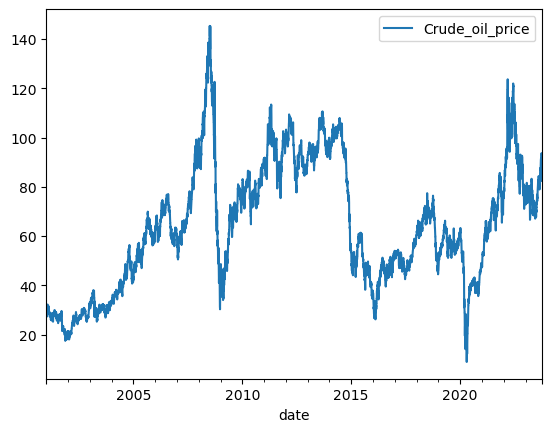

In [5]:
df.plot()

In [6]:
df = np.log(df)
df.head()

,Crude_oil_price
date,
2001-01-02,3.306520
2001-01-03,3.329701
2001-01-04,3.330417
2001-01-05,3.332919
2001-01-06,3.312002


<Axes: xlabel='date'>

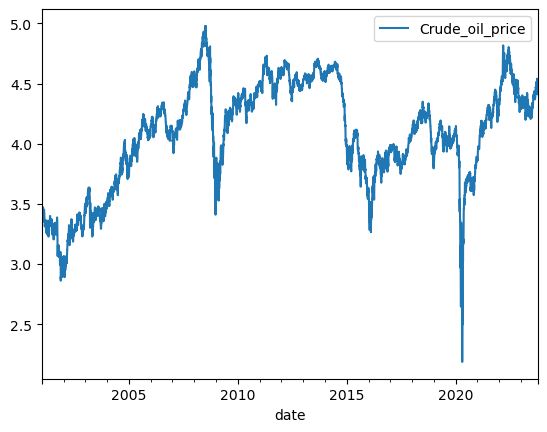

In [7]:
df.plot()

In [8]:
# Setting 80 percent data for training
training_data_len = math.ceil(len(df) * .8)
training_data_len

#Splitting the dataset
train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(6654, 1) (1663, 1)


## Check stationarity

#### According to the plot the TS plot seems to be non-stationarity. We can check that using ACF and PACF plots. Also we can use ADF test as well

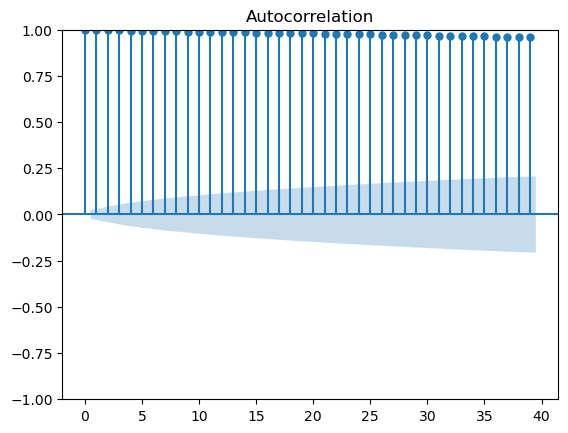

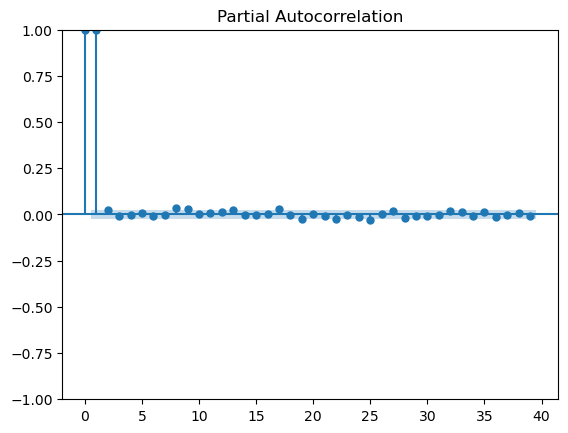

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(train_data)

pacf_original = plot_pacf(train_data)

* ACF plot show the correlation lag values are very high and they decade slightly with the time tag
* PACF plot show that there is a single spike at time lag one
* This indicates that the time series data is non stationary

In [10]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_data)
print(f'p-value: {adf_test[1]}')

p-value: 0.25815861499097426


* Null hypothesis: There is a unit unit (non-stationary)
* The p-value is greater than 0.05 which indicates that we cannot reject the NULL hypothesis. That means this data is non-stationary

## Transform to stationary: differencing

<Axes: xlabel='date'>

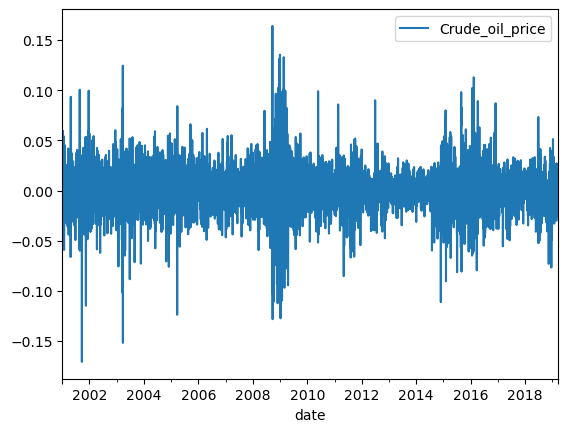

In [11]:
df_train_diff = train_data.diff().dropna()
df_train_diff.plot()

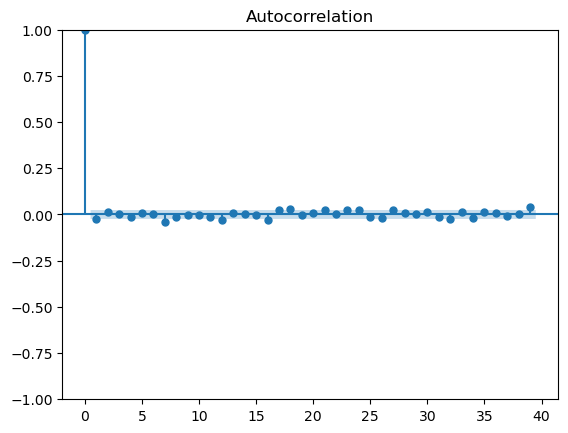

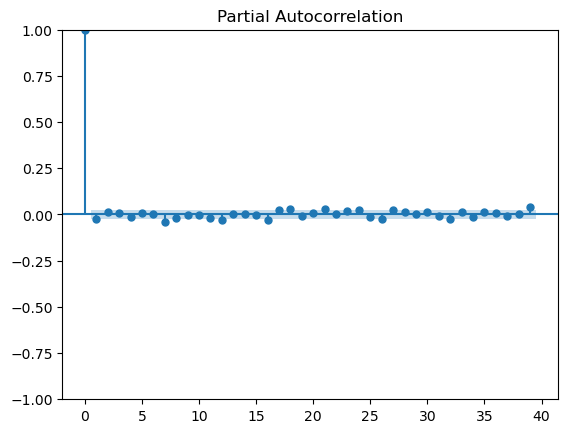

In [12]:
acf_diff = plot_acf(df_train_diff)

pacf_diff = plot_pacf(df_train_diff)

In [13]:
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 8.747010817604293e-28


* Null hypothesis: There is a unit unit (non-stationary)
* The p-value is less than 0.05 which indicates that we can reject the NULL hypothesis. That means 1 st difference data is stationary

## Determine ARIMA models parameters p, q

In [14]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())

/Users/thilina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/thilina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/thilina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:        Crude_oil_price   No. Observations:                 6654
Model:                 ARIMA(1, 1, 0)   Log Likelihood               16614.243
Date:                Mon, 05 Aug 2024   AIC                         -33224.485
Time:                        08:24:21   BIC                         -33210.880
Sample:                    01-02-2001   HQIC                        -33219.785
                         - 03-22-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0230      0.007     -3.129      0.002      -0.037      -0.009
sigma2         0.0004   3.08e-06    128.690      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

## Make time series predictions

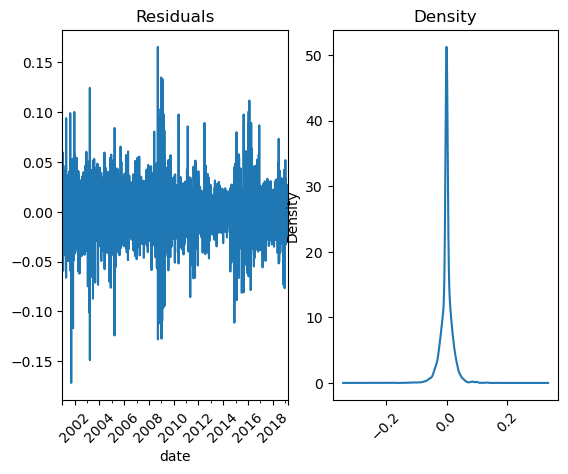

In [15]:
import matplotlib.pyplot as plt

residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1, 2)

residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])

# Rotate x-axis ticks for both subplots
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45)

plt.show()

* Model fits well

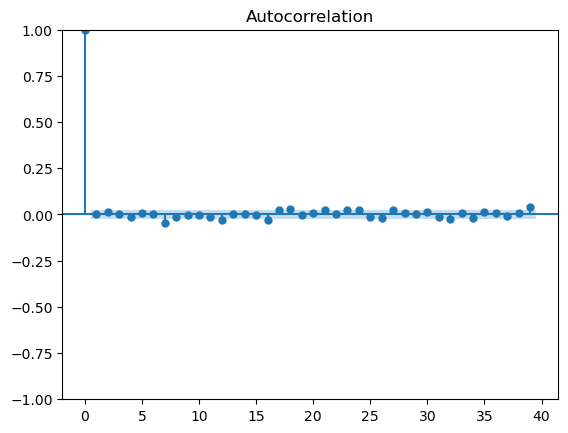

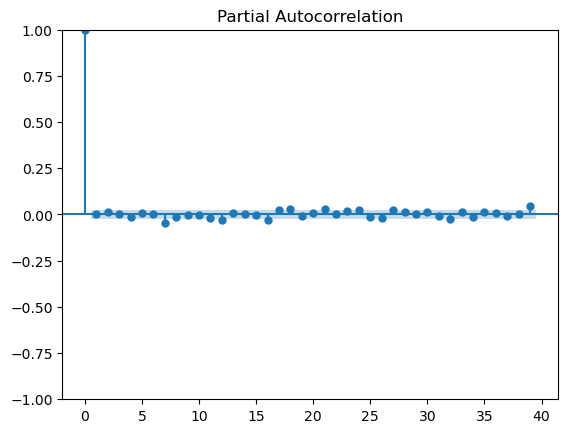

In [16]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

* Cannot see significant spikes. That means the residuals are white noise

<Axes: xlabel='date'>

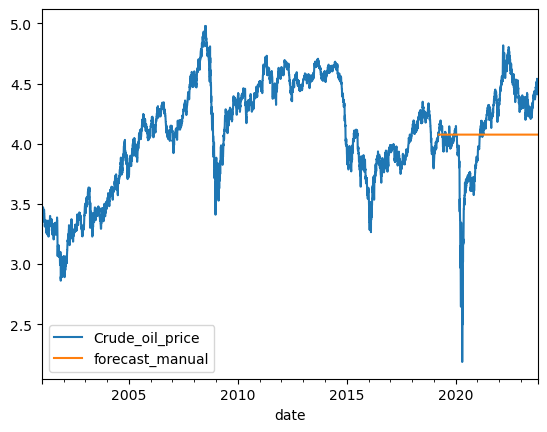

In [17]:
forecast_test = model_fit.forecast(len(test_data))

df['forecast_manual'] = [None]*len(train_data) + list(forecast_test)

df.plot()

# Optional: Auto-fit the ARIMA model

In [18]:
import pmdarima as pm
auto_arima = pm.auto_arima(train_data, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

In [19]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6654
Model:               SARIMAX(1, 1, 0)   Log Likelihood               16614.360
Date:                Mon, 05 Aug 2024   AIC                         -33222.719
Time:                        08:25:00   BIC                         -33202.311
Sample:                    01-02-2001   HQIC                        -33215.669
                         - 03-22-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.470      0.639      -0.000       0.001
ar.L1         -0.0231      0.007     -3.131      0.002      -0.038      -0.009
sigma2         0.0004   3.08e-06    128.639      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             17672.58
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='date'>

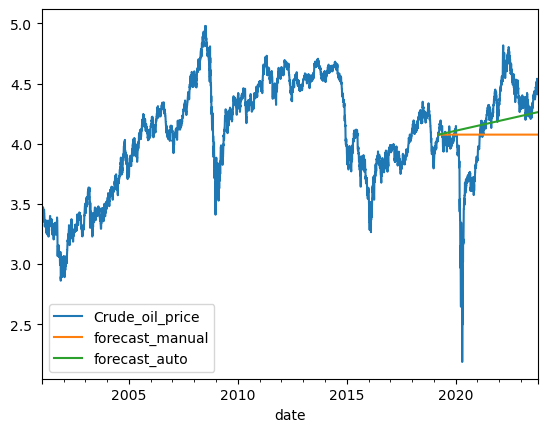

In [20]:
forecast_test_auto = auto_arima.predict(n_periods=len(test_data))
df['forecast_auto'] = [None]*len(train_data) + list(forecast_test_auto)

df.plot()

In [21]:
# Inverse transform the forecasted values (from log scale to original scale)
forecast_test_original = np.exp(forecast_test)
forecast_test_auto_original = np.exp(forecast_test_auto)

# Inverse transform the actual test data (from log scale to original scale)
test_data_original = np.exp(test_data)

# Calculate the RMSE and MSE on the original scale
rmse_manual = np.sqrt(mean_squared_error(test_data_original, forecast_test_original))
mse_manual = mean_squared_error(test_data_original, forecast_test_original)

rmse_auto = np.sqrt(mean_squared_error(test_data_original, forecast_test_auto_original))
mse_auto = mean_squared_error(test_data_original, forecast_test_auto_original)

print(f'RMSE (manual): {rmse_manual}')
print(f'MSE (manual): {mse_manual}')
print(f'RMSE (auto): {rmse_auto}')
print(f'MSE (auto): {mse_auto}')


RMSE (manual): 23.020745697621912
MSE (manual): 529.9547324745778
RMSE (auto): 19.40261560909193
MSE (auto): 376.46149247417793
